# Biosignal Analytics 2022
## EEG seizure detection

- Lauri Orava, 516761, laorav@utu.fi
- Emilia Kalliokoski, 2100413, emamka@utu.fi

### Library imports and data loading

In [1]:
# Library imports

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import scipy
from IPython.display import display
import seaborn as sns

from scipy import signal
from sklearn import preprocessing

from scipy.signal import freqz, butter, lfilter

from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import entropy

In [2]:
# Create lists of raw data
PATH_ns = os.path.join(os.getcwd(), 'Data', 'nonseizure')
PATH_s = os.path.join(os.getcwd(), 'Data', 'seizure')

raw_data_ns = []
raw_data_s = []

for file in glob.glob((PATH_ns+"/*.csv")):
    data = pd.read_csv(file)
    raw_data_ns.append(data)

for file in glob.glob((PATH_s+"/*.csv")):
    data = pd.read_csv(file)
    raw_data_s.append(data)

### Basic visualization of data

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

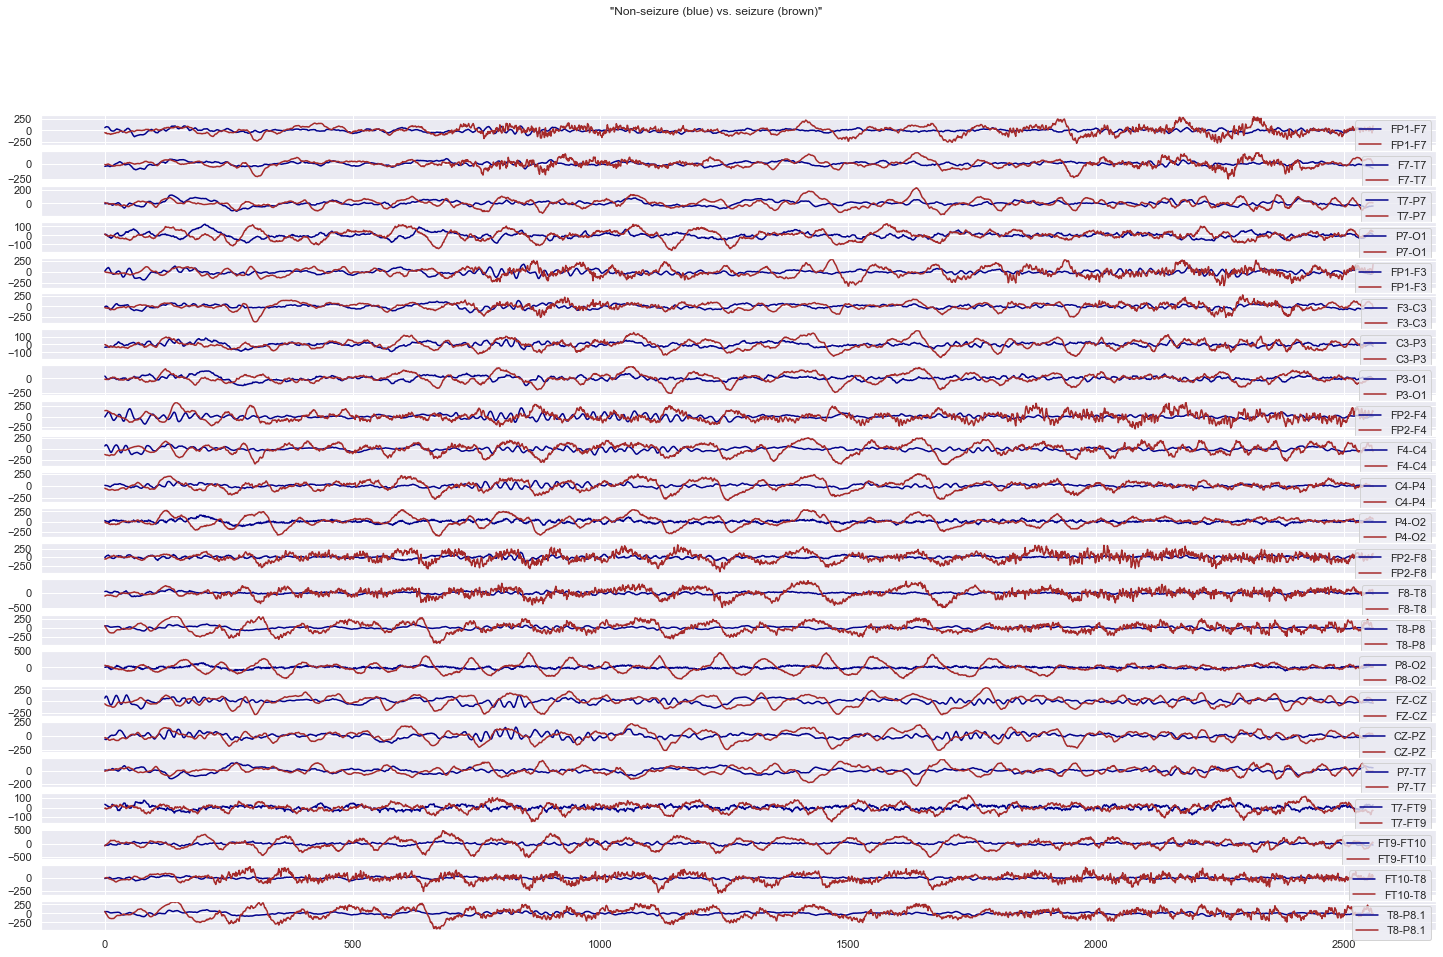

In [45]:
# Visualize data to better understand it

eeg_df_ns = raw_data_ns[0]
ax = eeg_df_ns.plot(subplots=True, figsize=(25, 15), color='darkblue')

eeg_df_s = raw_data_s[0]
eeg_df_s.plot(ax=ax, subplots=True, figsize=(25, 15), color='brown', title='"Non-seizure (blue) vs. seizure (brown)"')

### Filtering

In [4]:
# Functions for filtering all of the data channels
def butter_bandpass_filter(lowcut, highcut, freq, order, data):
  sampling_rate = 0.5*freq
  b,a = butter(order, [lowcut/sampling_rate, highcut/sampling_rate], btype = 'band')
  y = lfilter(b,a,data)
  return y

def bb_filter_eeg_samples(data, lowcut, highcut, freq, order):
  filtered_data = []
  for i in range (0, len(data)):
    temp_df = data[i]
    filtered = dict()
    for j in temp_df.columns:
      channel = temp_df[j].values
      filtered[j] = butter_bandpass_filter(lowcut, highcut, freq, order, channel)
    filtered_data.append(pd.DataFrame.from_dict(filtered))
  return filtered_data

In [5]:
# Filtering the data with the Butterworth bandpass filter
# Low-pass and high-pass frequencies chosen based on typical practices
s_filtered = bb_filter_eeg_samples(raw_data_s, 0.1, 50, 256, 4)
ns_filtered = bb_filter_eeg_samples(raw_data_ns, 0.1, 50, 256, 4)

### Feature extraction

#### Summary statistics and entropy

In [6]:
# Extract summary statistics (mean, standard deviation, median and entropy) from EEG data
def summary_statistics_eeg(data):
    means = pd.DataFrame(columns=list(data[0].columns + ' mean'))
    stds = pd.DataFrame(columns=list(data[0].columns + ' std'))
    medians = pd.DataFrame(columns=list(data[0].columns + ' md'))
    for i in range (0, len(data)):
        temp_df = data[i]
        mean = []
        std = []
        median = []
        for j in range(0, len(temp_df.columns)):
            mean.append(temp_df.iloc[:, j].mean())
            std.append(temp_df.iloc[:, j].std())
            median.append(temp_df.iloc[:, j].median())
        means.loc[i] = mean
        stds.loc[i] = std
        medians.loc[i] = median
    summary_statistics = pd.concat([means, stds, medians], axis=1)
    return summary_statistics

In [7]:
def entropy_eeg(data):
    entropies = pd.DataFrame(columns=list(data[0].columns + ' entropy'))
    for i in range (0, len(data)):
        temp_df = data[i]
        entropylist = []
        for j in range(0, len(temp_df.columns)):
            entropylist.append(entropy(temp_df.iloc[:, j].value_counts()))
        entropies.loc[i] = entropylist
    return entropies

In [8]:
# Extract summary statistics using our function from all of the (un)filtered (non)seizure data channels
raw_ns_stats = summary_statistics_eeg(raw_data_ns)
raw_s_stats = summary_statistics_eeg(raw_data_s)
filtered_ns_stats = summary_statistics_eeg(ns_filtered)
filtered_s_stats = summary_statistics_eeg(s_filtered)

In [9]:
# Extract entropies for only unfiltered data
unfiltered_ns_entropies = entropy_eeg(raw_data_ns)
unfiltered_s_entropies = entropy_eeg(raw_data_s)

#### PSD bins and dominant frequency

In [10]:
# Column names for PSD bin dataframe
bin_df_columns = []
for i in range(0, len(raw_data_s[0].columns)):
    for j in range(1,6):
        bin_df_columns.append(raw_data_s[0].columns[i] + " bin " + str(j))

# Column names for dominant frequency dataframe
dom_freq_columns = []
for i in range(0, len(raw_data_s[0].columns)):
    dom_freq_columns.append(raw_data_s[0].columns[i] + " dom freq")

In [11]:
def PSD_DF_bins(data, freq, freqs_array):
    psd_array = []
    df_array = []
    for i in range(0, len(data)):
        norm_sample = preprocessing.scale(data[i])
        temp_psd_array = []
        temp_df_array = []
        for j in range(0, norm_sample.shape[1]):
            frequencies, PSD = signal.welch(norm_sample[:,j], fs=freq, nperseg=10*freq)
            temp_df_array.append(frequencies[PSD.tolist().index(max(PSD))])
            PSD_bin_sum = []
            for k in range(freqs_array.shape[0]-1):
                PSD_bin_sum.append(np.sum(PSD[np.where((frequencies >= freqs_array[k]) & (frequencies < freqs_array[k+1]))]))
            for l in PSD_bin_sum:
                temp_psd_array.append(l)
        psd_array.append(temp_psd_array)
        df_array.append(temp_df_array)
    final_psd_dataframe = pd.DataFrame(psd_array, columns=bin_df_columns)
    final_df_dataframe = pd.DataFrame(df_array, columns=dom_freq_columns)
    return final_psd_dataframe, final_df_dataframe

In [12]:
# Data is divided into five bins, amount of bins subject to change
freqs_arr = np.arange(0,51,10)

# PSD bins and dominant frequencies for unfiltered non-seizure and seizure data
unfiltered_ns_bin_df, unfiltered_ns_dom_freqs_df = PSD_DF_bins(raw_data_ns, 256, freqs_arr)
unfiltered_s_bin_df, unfiltered_s_dom_freqs_df = PSD_DF_bins(raw_data_s, 256, freqs_arr)
filtered_ns_bin_df, filtered_ns_dom_freqs_df = PSD_DF_bins(ns_filtered, 256, freqs_arr)
filtered_s_bin_df, filtered_s_dom_freqs_df = PSD_DF_bins(s_filtered, 256, freqs_arr)

#### Prepare final feature dataframes

In [13]:
# Concatenate all extracted features into one dataframe and add labels (non-seizure = 0, seizure = 1)
unfiltered_ns_features = pd.concat([raw_ns_stats, unfiltered_ns_entropies, unfiltered_ns_bin_df, unfiltered_ns_dom_freqs_df], axis=1)
unfiltered_ns_features['label'] = 0

unfiltered_s_features = pd.concat([raw_s_stats, unfiltered_s_entropies, unfiltered_s_bin_df, unfiltered_s_dom_freqs_df], axis=1)
unfiltered_s_features['label'] = 1

filtered_ns_features = pd.concat([filtered_ns_stats, filtered_ns_bin_df, filtered_ns_dom_freqs_df], axis=1)
filtered_ns_features['label'] = 0

filtered_s_features = pd.concat([filtered_s_stats, filtered_s_bin_df, filtered_s_dom_freqs_df], axis=1)
filtered_s_features['label'] = 1

unfiltered_features = pd.concat([unfiltered_ns_features, unfiltered_s_features], axis=0)
filtered_features = pd.concat([filtered_ns_features, filtered_s_features], axis=0)

In [14]:
# Display first five rows from both complete feature dataframes to check results
display(unfiltered_features.head())
display(filtered_features.head())

,FP1-F7 mean,F7-T7 mean,T7-P7 mean,P7-O1 mean,FP1-F3 mean,F3-C3 mean,C3-P3 mean,P3-O1 mean,FP2-F4 mean,F4-C4 mean,...,T8-P8 dom freq,P8-O2 dom freq,FZ-CZ dom freq,CZ-PZ dom freq,P7-T7 dom freq,T7-FT9 dom freq,FT9-FT10 dom freq,FT10-T8 dom freq,T8-P8.1 dom freq,label
0,-0.402778,0.211538,-0.701465,0.846154,-0.496490,-0.704060,0.329060,0.652167,-1.004884,-0.323718,...,3.3,0.7,1.1,0.5,0.9,1.2,1.6,3.3,3.3,0
1,0.508394,2.308455,3.862790,1.992521,-0.456807,2.598291,2.872863,3.744505,-0.287393,-1.392094,...,1.2,1.2,1.0,1.2,1.1,1.9,1.3,1.0,1.2,0
2,-0.574786,-1.023352,0.308913,1.052198,0.401404,-0.833639,0.191850,0.074023,0.599512,0.193529,...,1.2,1.1,0.6,1.1,1.0,1.6,16.0,1.1,1.2,0
3,-0.916972,0.786325,-0.688187,-1.084707,-0.556471,0.299756,-1.157967,-0.459707,-0.045177,-1.033730,...,1.0,1.0,0.9,1.0,1.5,16.0,16.0,1.1,1.0,0
4,0.145604,-0.903694,0.749389,-0.057387,0.272894,-1.247711,0.708486,0.190934,-0.590965,0.114469,...,0.9,1.4,1.3,0.7,0.9,2.9,1.7,1.5,0.9,0


,FP1-F7 mean,F7-T7 mean,T7-P7 mean,P7-O1 mean,FP1-F3 mean,F3-C3 mean,C3-P3 mean,P3-O1 mean,FP2-F4 mean,F4-C4 mean,...,T8-P8 dom freq,P8-O2 dom freq,FZ-CZ dom freq,CZ-PZ dom freq,P7-T7 dom freq,T7-FT9 dom freq,FT9-FT10 dom freq,FT10-T8 dom freq,T8-P8.1 dom freq,label
0,-0.131554,-0.501791,-0.726000,-0.173997,-0.255233,-1.096756,-0.200321,-0.013930,-0.324634,-0.453929,...,3.3,0.7,1.1,0.5,0.9,1.2,1.6,3.3,3.3,0
1,0.996941,0.755209,0.756227,0.180929,0.855353,0.888275,0.284219,0.610353,-0.079233,1.114721,...,1.2,1.1,1.0,1.2,1.1,1.9,1.3,1.0,1.2,0
2,-0.135983,-0.600559,0.025540,0.801158,0.119470,-0.729644,0.438663,0.246708,0.191823,0.647983,...,1.2,1.1,0.6,1.1,1.0,1.6,16.0,1.1,1.2,0
3,-0.356652,0.154665,-0.409141,-0.067626,-0.228158,0.014711,-0.208863,-0.254026,-0.134526,-0.458166,...,1.0,1.0,0.9,1.0,1.5,16.0,16.0,1.1,1.0,0
4,0.474739,-0.912563,-0.714783,-0.714853,1.117148,-1.714395,-0.422421,-0.880638,0.277384,-0.552908,...,0.9,1.4,1.3,0.7,0.9,2.9,1.7,1.5,0.9,0


### Split data to train and test sets

In [15]:
# Dividing the complete dataframes into X (features) and y (labels)
unfiltered_X = unfiltered_features.iloc[:, :len(unfiltered_features.columns)-1]
unfiltered_y = unfiltered_features.iloc[:, len(unfiltered_features.columns)-1:]

filtered_X = filtered_features.iloc[:, :len(filtered_features.columns)-1]
filtered_y = filtered_features.iloc[:, len(filtered_features.columns)-1:]

In [16]:
# Dividing the data into training (70 %) and testing (30 %) sets. We use a seed number to get same resuls each time the code is run for better comparison
unfiltered_X_train, unfiltered_X_test, unfiltered_y_train, unfiltered_y_test = train_test_split(unfiltered_X, unfiltered_y, test_size=0.3, train_size=0.7, random_state=112233, shuffle=True)

filtered_X_train, filtered_X_test, filtered_y_train, filtered_y_test = train_test_split(filtered_X, filtered_y, test_size=0.3, train_size=0.7, random_state=112233, shuffle=True)

#### Standardizing datasets

In [17]:
# Calculating mean and stds of the unfiltered and filtered training sets
unfiltered_X_train_mean = unfiltered_X_train.mean()
unfiltered_X_train_std = unfiltered_X_train.std()
filtered_X_train_mean = filtered_X_train.mean()
filtered_X_train_std = filtered_X_train.std()

In [18]:
# Stanzardizing the training and testing sets using means and stds of the training sets
# Regular Z-score standardization is used ((X - mean) / std)
unfiltered_X_train_z = (unfiltered_X_train - unfiltered_X_train_mean) / unfiltered_X_train_std
unfiltered_X_test_z = (unfiltered_X_test - unfiltered_X_train_mean) / unfiltered_X_train_std
filtered_X_train_z = (filtered_X_train - filtered_X_train_mean) / filtered_X_train_std
filtered_X_test_z = (filtered_X_test - filtered_X_train_mean) / filtered_X_train_std

In [19]:
# Converting dataframes to numpys for easier use

unfiltered_X_train_z_np = unfiltered_X_train_z.to_numpy()
unfiltered_y_train_np = unfiltered_y_train.to_numpy()
unfiltered_X_test_z_np = unfiltered_X_test_z.to_numpy()
unfiltered_y_test_np = unfiltered_y_test.to_numpy()

filtered_X_train_z_np = filtered_X_train_z.to_numpy()
filtered_y_train_np = filtered_y_train.to_numpy()
filtered_X_test_z_np = filtered_X_test_z.to_numpy()
filtered_y_test_np = filtered_y_test.to_numpy()

## Fitting into machine learning classification models
### Logistic regression

In [20]:
### Logistic regression for binary classification

## Unfiltered data

# Logistic regression model
unfiltered_logit = LogisticRegression(solver='lbfgs', max_iter=1000).fit(unfiltered_X_train_z_np, unfiltered_y_train_np.ravel())
unfiltered_logit_preds = unfiltered_logit.predict(unfiltered_X_test_z_np)

print("For unfiltered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(unfiltered_y_test_np, unfiltered_logit_preds))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(unfiltered_y_test_np, unfiltered_logit_preds)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(unfiltered_y_test_np, unfiltered_logit_preds))

## Filtered data

# Logistic regression model
filtered_logit = LogisticRegression(solver='lbfgs', max_iter=1000).fit(filtered_X_train_z_np, filtered_y_train_np.ravel())
filtered_logit_preds = filtered_logit.predict(filtered_X_test_z_np)

print("\nFor filtered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(filtered_y_test_np, filtered_logit_preds))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(filtered_y_test_np, filtered_logit_preds)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(filtered_y_test_np, filtered_logit_preds))

For unfiltered data: 

Confusion matrix:
[[114   5]
 [  5  98]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       119
           1       0.95      0.95      0.95       103

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222

Accuracy:  0.954954954954955

For filtered data: 

Confusion matrix:
[[113   6]
 [  6  97]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       119
           1       0.94      0.94      0.94       103

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222

Accuracy:  0.9459459459459459


### Random forest

In [21]:
### Random forest

## Unfiltered data

# Random forest model
unfiltered_forest = RandomForestClassifier(n_estimators=100).fit(unfiltered_X_train_z_np, unfiltered_y_train_np.ravel())

unfiltered_forest_preds = unfiltered_forest.predict(unfiltered_X_test_z_np)

print("For unfiltered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(unfiltered_y_test_np, unfiltered_forest_preds))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(unfiltered_y_test_np, unfiltered_forest_preds)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(unfiltered_y_test_np, unfiltered_forest_preds))

## Filtered data

# Random forest model
filtered_forest = RandomForestClassifier(n_estimators=100).fit(filtered_X_train_z_np, filtered_y_train_np.ravel())

filtered_forest_preds = filtered_forest.predict(filtered_X_test_z_np)

print("For filtered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(filtered_y_test_np, filtered_forest_preds))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(filtered_y_test_np, filtered_forest_preds)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(filtered_y_test_np, filtered_forest_preds))

For unfiltered data: 

Confusion matrix:
[[117   2]
 [  3 100]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       119
           1       0.98      0.97      0.98       103

    accuracy                           0.98       222
   macro avg       0.98      0.98      0.98       222
weighted avg       0.98      0.98      0.98       222

Accuracy:  0.9774774774774775
For filtered data: 

Confusion matrix:
[[117   2]
 [  6  97]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       119
           1       0.98      0.94      0.96       103

    accuracy                           0.96       222
   macro avg       0.97      0.96      0.96       222
weighted avg       0.96      0.96      0.96       222

Accuracy:  0.963963963963964


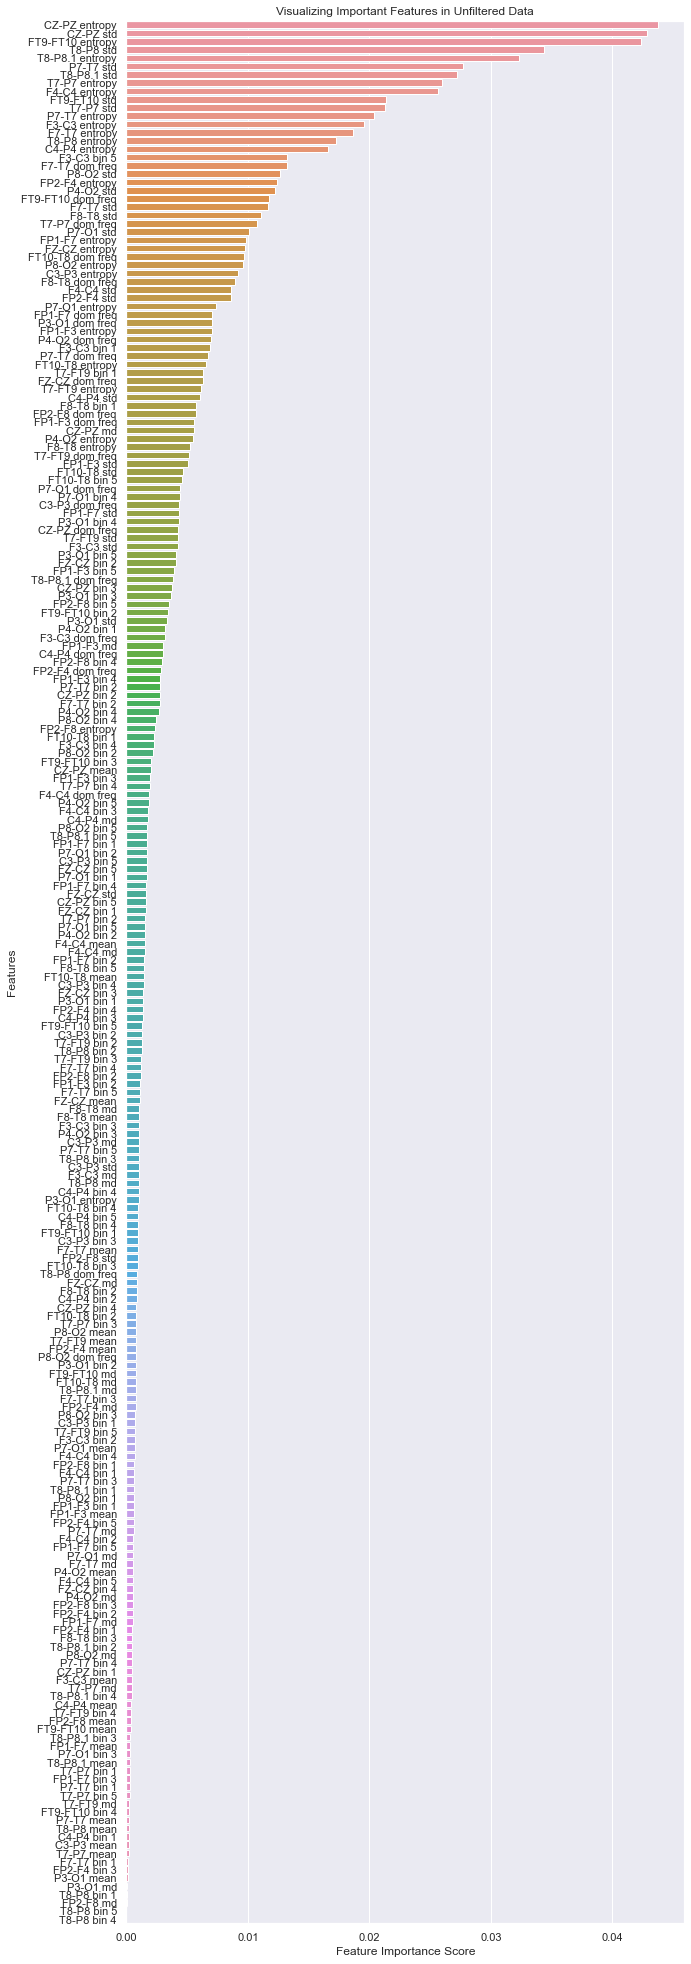

In [22]:
# Feature importance in random forest for unfiltered data
feature_imp_unf = pd.Series(unfiltered_forest.feature_importances_,index=unfiltered_X_train_z.columns).sort_values(ascending=False)

%matplotlib inline
# Creating a bar plot
sns.set(rc = {'figure.figsize':(10,35)})
sns.barplot(x=feature_imp_unf, y=feature_imp_unf.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features in Unfiltered Data")
plt.show()

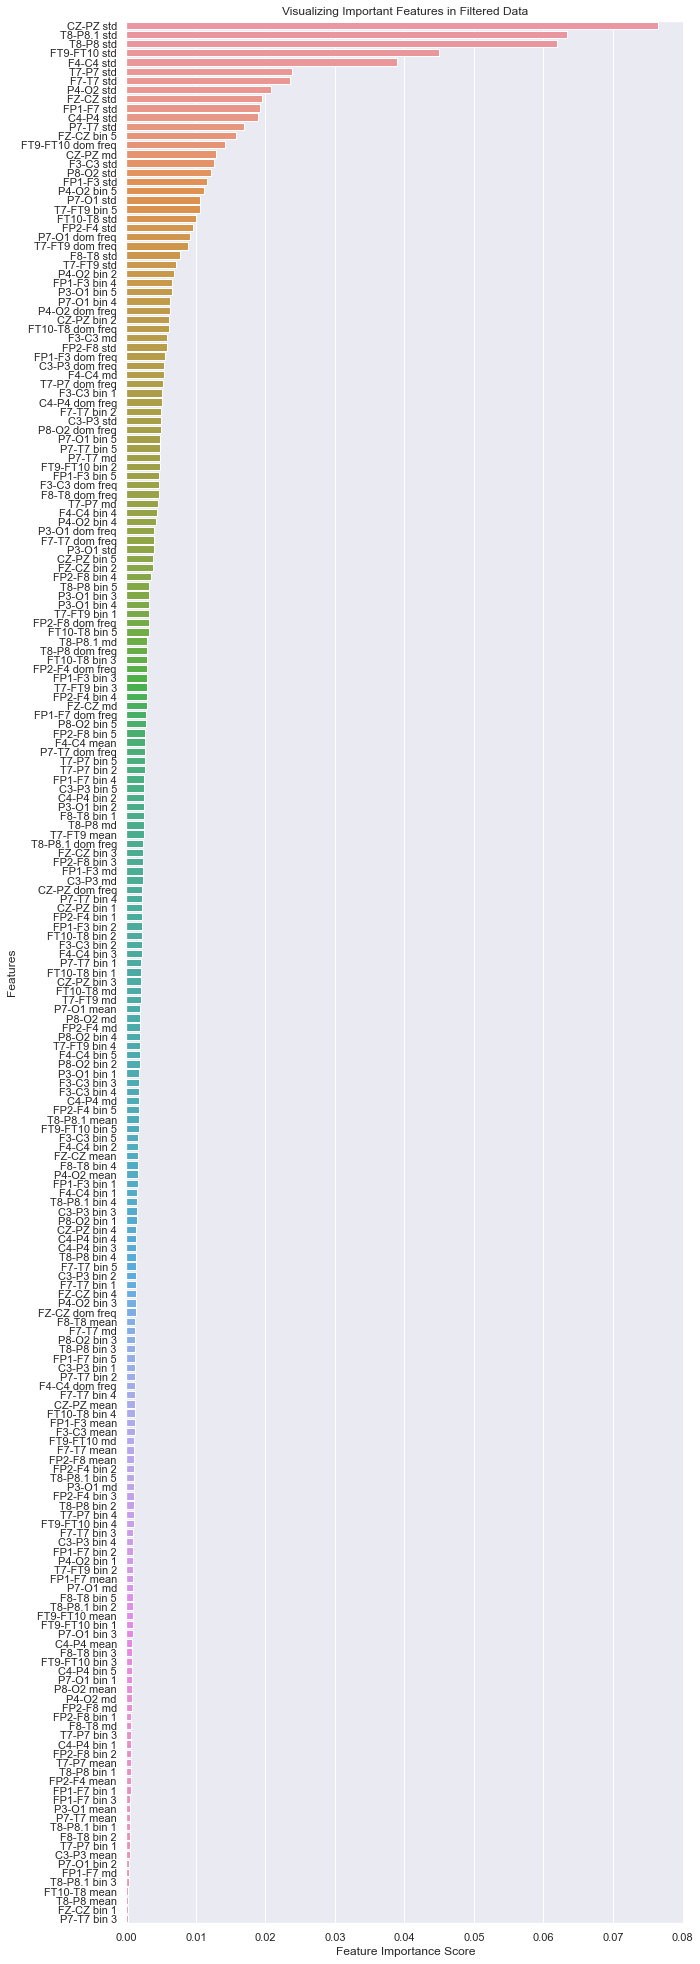

In [23]:
# Feature importance in random forest for filtered data
feature_imp_f = pd.Series(filtered_forest.feature_importances_,index=filtered_X_train_z.columns).sort_values(ascending=False)

%matplotlib inline
# Creating a bar plot
sns.set(rc = {'figure.figsize':(10,35)})
sns.barplot(x=feature_imp_f, y=feature_imp_f.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features in Filtered Data")
plt.show()

### Support vector machine

In [24]:
### Support vector machine

## Unfiltered data

# SVM model

unfiltered_svm = svm.SVC(kernel="rbf").fit(unfiltered_X_train_z_np, unfiltered_y_train_np.ravel())
unfiltered_svm_preds = unfiltered_svm.predict(unfiltered_X_test_z_np)

print("For unfiltered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(unfiltered_y_test_np, unfiltered_svm_preds))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(unfiltered_y_test_np, unfiltered_svm_preds)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(unfiltered_y_test_np, unfiltered_svm_preds))

## Filtered data

# SVM model

filtered_svm = svm.SVC(kernel="rbf").fit(filtered_X_train_z_np, filtered_y_train_np.ravel())
filtered_svm_preds = filtered_svm.predict(filtered_X_test_z_np)

print("\nFor filtered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(filtered_y_test_np, filtered_svm_preds))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(filtered_y_test_np, filtered_svm_preds)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(filtered_y_test_np, filtered_svm_preds))

For unfiltered data: 

Confusion matrix:
[[115   4]
 [  5  98]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       119
           1       0.96      0.95      0.96       103

    accuracy                           0.96       222
   macro avg       0.96      0.96      0.96       222
weighted avg       0.96      0.96      0.96       222

Accuracy:  0.9594594594594594

For filtered data: 

Confusion matrix:
[[115   4]
 [ 12  91]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.93       119
           1       0.96      0.88      0.92       103

    accuracy                           0.93       222
   macro avg       0.93      0.92      0.93       222
weighted avg       0.93      0.93      0.93       222

Accuracy:  0.9279279279279279


## After PCA

In [25]:
# PCA with 30 components to reduce the amount of features

unfiltered_train_pca = PCA(n_components=30)
unfiltered_X_train_pca = unfiltered_train_pca.fit_transform(unfiltered_X_train_z_np)

filtered_train_pca = PCA(n_components=30)
filtered_X_train_pca = filtered_train_pca.fit_transform(filtered_X_train_z_np)

unfiltered_test_pca = PCA(n_components=30)
unfiltered_X_test_pca = unfiltered_test_pca.fit_transform(unfiltered_X_test_z_np)

filtered_test_pca = PCA(n_components=30)
filtered_X_test_pca = filtered_test_pca.fit_transform(filtered_X_test_z_np)

### Logistic regression

In [26]:
### Logistic regression for PCA data

## Unfiltered data

# Logistic regression model
unfiltered_logit_pca = LogisticRegression().fit(unfiltered_X_train_pca, unfiltered_y_train_np.ravel())
unfiltered_logit_preds_pca = unfiltered_logit_pca.predict(unfiltered_X_test_pca)

print("For unfiltered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(unfiltered_y_test_np, unfiltered_logit_preds_pca))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(unfiltered_y_test_np, unfiltered_logit_preds_pca)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(unfiltered_y_test_np, unfiltered_logit_preds_pca))

## Filtered data

# Logistic regression model
filtered_logit_pca = LogisticRegression().fit(filtered_X_train_pca, filtered_y_train_np.ravel())
filtered_logit_preds_pca = filtered_logit_pca.predict(filtered_X_test_pca)

print("\nFor filtered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(filtered_y_test_np, filtered_logit_preds_pca))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(filtered_y_test_np, filtered_logit_preds_pca)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(filtered_y_test_np, filtered_logit_preds_pca))

For unfiltered data: 

Confusion matrix:
[[92 27]
 [17 86]]
              precision    recall  f1-score   support

           0       0.84      0.77      0.81       119
           1       0.76      0.83      0.80       103

    accuracy                           0.80       222
   macro avg       0.80      0.80      0.80       222
weighted avg       0.81      0.80      0.80       222

Accuracy:  0.8018018018018018

For filtered data: 

Confusion matrix:
[[87 32]
 [24 79]]
              precision    recall  f1-score   support

           0       0.78      0.73      0.76       119
           1       0.71      0.77      0.74       103

    accuracy                           0.75       222
   macro avg       0.75      0.75      0.75       222
weighted avg       0.75      0.75      0.75       222

Accuracy:  0.7477477477477478


### Support vector machine

In [27]:
### Support vector machine for PCA data

## Unfiltered data

# SVM model

unfiltered_svm_pca = svm.SVC(kernel="rbf").fit(unfiltered_X_train_pca, unfiltered_y_train_np.ravel())
unfiltered_svm_preds_pca = unfiltered_svm_pca.predict(unfiltered_X_test_pca)

print("For unfiltered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(unfiltered_y_test_np, unfiltered_svm_preds_pca))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(unfiltered_y_test_np, unfiltered_svm_preds_pca)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(unfiltered_y_test_np, unfiltered_svm_preds_pca))

## Filtered data

# SVM model

filtered_svm_pca = svm.SVC(kernel="rbf").fit(filtered_X_train_pca, filtered_y_train_np.ravel())
filtered_svm_preds_pca = filtered_svm_pca.predict(filtered_X_test_pca)

print("\nFor filtered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(filtered_y_test_np, filtered_svm_preds_pca))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(filtered_y_test_np, filtered_svm_preds_pca)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(filtered_y_test_np, filtered_svm_preds_pca))

For unfiltered data: 

Confusion matrix:
[[102  17]
 [ 16  87]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       119
           1       0.84      0.84      0.84       103

    accuracy                           0.85       222
   macro avg       0.85      0.85      0.85       222
weighted avg       0.85      0.85      0.85       222

Accuracy:  0.8513513513513513

For filtered data: 

Confusion matrix:
[[104  15]
 [ 22  81]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       119
           1       0.84      0.79      0.81       103

    accuracy                           0.83       222
   macro avg       0.83      0.83      0.83       222
weighted avg       0.83      0.83      0.83       222

Accuracy:  0.8333333333333334


In [29]:
### Random forest for PCA

## Unfiltered data

# Random forest model
unfiltered_forest_pca = RandomForestClassifier(n_estimators=30).fit(unfiltered_X_train_pca, unfiltered_y_train_np.ravel())
unfiltered_forest_preds_pca = unfiltered_forest_pca.predict(unfiltered_X_test_pca)

print("For unfiltered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(unfiltered_y_test_np, unfiltered_forest_preds_pca))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(unfiltered_y_test_np, unfiltered_forest_preds_pca)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(unfiltered_y_test_np, unfiltered_forest_preds_pca))

## Filtered data

# Random forest model
filtered_forest_pca = RandomForestClassifier(n_estimators=30).fit(filtered_X_train_pca, filtered_y_train_np.ravel())
filtered_forest_preds_pca = filtered_forest_pca.predict(filtered_X_test_pca)

print("\nFor filtered data: \n")
# Confusion matrix
print("Confusion matrix:")
print(metrics.confusion_matrix(filtered_y_test_np, filtered_forest_preds_pca))

# Precision, recall, f1-score (and accuracy)
print(metrics.classification_report(filtered_y_test_np, filtered_forest_preds_pca)) 

# Accuracy
print("Accuracy: ",metrics.accuracy_score(filtered_y_test_np, filtered_forest_preds_pca))

For unfiltered data: 

Confusion matrix:
[[103  16]
 [ 18  85]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       119
           1       0.84      0.83      0.83       103

    accuracy                           0.85       222
   macro avg       0.85      0.85      0.85       222
weighted avg       0.85      0.85      0.85       222

Accuracy:  0.8468468468468469

For filtered data: 

Confusion matrix:
[[98 21]
 [23 80]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       119
           1       0.79      0.78      0.78       103

    accuracy                           0.80       222
   macro avg       0.80      0.80      0.80       222
weighted avg       0.80      0.80      0.80       222

Accuracy:  0.8018018018018018


- Features were extracted and analysis was done on both unfiltered and filtered data. This was done to figure out if filtering the data improves the results of the analysis.
- Filtering was done with a Butterworth bandpass filter with 0.1 and 50 as the boundaries. We decided on these numbers as they were mentioned as common choices as the boundaries for filtering EEG data.
- For both unfiltered and filtered data, means, standard deviations and medians were first extracted. We also calculated power spectral densities for both data using five bins. Later on we also added dominant frequencies and entropies to the features. Entropies were only calculated for the unfiltered data, as the entropies were pretty much the same for all filtered signals: this might be due to there being a number in the filtered data that repeats a lot, for example.

- Both data were split into train (70 %) and test (30 %) sets, and they both were stanzardized with z-score normalization before analysis. The unfiltered train and test sets were standardized using the mean and std of the unfiltered train set, and the filtered train and test sets were standardized using the mean and std of the filtered train set.

- For the machine learning algorithms, we chose logistic regression and support vector machine. We chose logistic regression because it's a very simple model to implement. SVM was chosen since it should work well with data that has a large amount of features. We also decided to try a random forest model, as it works well with a lot of features too, and it provides an easy way to see which features are important in making the decisions.

- Different kernels for SVM and number of trees for random forests were tried. For SVM, the default "rbf"-kernel yielded the best results. For the random forest, tree amounts ranging from 60 to 120 were tried. Not much difference was found between the accuracies when changing the amount of trees, so we decided on 100 since it seemed like a safe choice.

- For filtered and unfiltered data, the results for all modeling techniques are quite similar, with accuracies ranging from 0.9 to 0.98. The results differed a little with different splits of the data -- sometimes logistic regression with unfiltered data gave the best results with accuracy of 0.97, while sometimes the best results were with a support vector machine on unfiltered data with an accuracy of 0.98.

- The most important features in the random forest model for unfiltered data are generally entropies, dominant frequencies and standard deviations. Before adding the entropies and dominant frequencies, the most important features were generally standard deviations and PSD bins 1 and 5.
- For filtered data, the most important features are standard deviations, and some dominant frequencies and PSD bins 5.
- For both unfiltered and filtered data, features extracted from channels T8-P8, CZ-PZ, P7-T7, T8-P8.1 and FT9-FT10 seemed to be on the top of the lists.

- We tried to reduce the dimensionality of the data with PCA of 30 components (different amounts were tried).
- Logistic regression had an accuracy of about 0.75-0.8, but with SVM and random forest the accuracy decreased only to about 0.8-0.85. These differed a bit with different random splits of the data.
- The accuracies of the algoritms were definitely lower with the PCA data, but the loss seems quite small when taking into account the very significant decrease in the amount of features, going from 207/230 to only 30.